In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
tau = 1.9029+np.pi
T = 2*np.pi
aa = 0.2
bb = 3
cc = 1.1133
def alt(tt):
    return np.sin(tt+tau)+aa*np.cos(bb*(tt+tau))+cc

def spe(tt):
    return np.cos(tt+tau)-bb*aa*np.sin(bb*(tt+tau))

def acc(tt):
    return -np.sin(tt+tau)-bb**2*aa*np.cos(bb*(tt+tau))

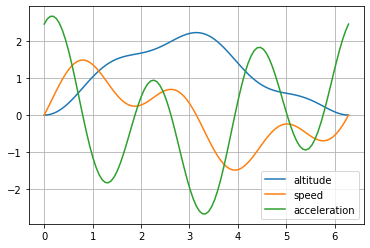

In [30]:
tt_dom = np.linspace(0, T, 101)
plt.plot(tt_dom, alt(tt_dom), label='altitude')
plt.plot(tt_dom, spe(tt_dom), label='speed')
plt.plot(tt_dom, acc(tt_dom), label='acceleration')


plt.grid()
plt.legend()

In [40]:
### Covariances
def kk(tau, ll):
    return np.exp(-1/2*(tau)**2/ll**2)

def kk_jj(tau, ll):
    return tau/ll**2*kk(tau, ll)

def kk_ii(tau, ll):
    return -kk_jj(tau, ll)

def kk_ii_jj(tau, ll):
    return 1/ll**2*(1-tau**2/ll**2)*kk(tau, ll)

def kk_ii_ii(tau, ll):
    return - kk_ii_jj(tau, ll)

def kk_jj_jj(tau, ll):
    return - kk_ii_jj(tau, ll)

def kk_ii_ii_jj(tau, ll):
    return tau/ll**4*(3-tau**2/ll**2)*kk(tau, ll)

def kk_ii_jj_jj(tau, ll):
    return - kk_ii_ii_jj(tau, ll)

def kk_ii_ii_jj_jj(tau, ll):
    return 1/ll**4*(3-6*tau**2/ll**2+tau**4/ll**4)*kk(tau, ll)

def kk_flow(tau, ll, str1, str2):
    if (str1, str2) == ('alt', 'alt'):
        return kk(tau, ll)
    if (str1, str2) == ('alt', 'spe'):
        return kk_jj(tau, ll)
    if (str1, str2) == ('alt', 'acc'):
        return kk_jj_jj(tau, ll)
    if (str1, str2) == ('spe', 'alt'):
        return kk_ii(tau, ll)
    if (str1, str2) == ('spe', 'spe'):
        return kk_ii_jj(tau, ll)
    if (str1, str2) == ('spe', 'acc'):
        return kk_ii_jj_jj(tau, ll)
    if (str1, str2) == ('acc', 'alt'):
        return kk_ii_ii(tau, ll)
    if (str1, str2) == ('acc', 'spe'):
        return kk_ii_ii_jj(tau, ll)
    if (str1, str2) == ('acc', 'acc'):
        return kk_ii_ii_jj_jj(tau, ll)


In [41]:
example_list = [(2, 'alt'), (2, 'spe'), (2, 'acc'),
                (3, 'alt'), (3, 'spe'),
                (4, 'alt')]

In [48]:
dom_list = [[tt, 'alt'] for tt in tt_dom]


In [45]:
def build_cov_mat(feature_list_ii, feature_list_jj, ll):
    # Each entry in the feature_list is a tuple
    # (feature value, type), e.g. (2, 'acc')
    N = len(feature_list_ii)
    M = len(feature_list_jj)
    
    K = np.zeros((N, M)) #initialise array
    for ii in range(N):
        (xx_ii, str_ii) = feature_list_ii[ii]
        for jj in range(M):
            (xx_jj, str_jj) = feature_list_jj[jj]
            K[ii, jj] = kk_flow(xx_ii-xx_jj, ll, str_ii, str_jj)
    return K

In [69]:
def build_samples_vec(feature_list, sigma_n):
    samples = []
    for (xx_ii, str_ii) in feature_list:
        if str_ii == 'alt':
            samples.append(alt(xx_ii)+np.random.normal(0, sigma_n))
        elif str_ii == 'spe':
            samples.append(spe(xx_ii)+np.random.normal(0, sigma_n))
        elif str_ii == 'acc':
            samples.append(acc(xx_ii)+np.random.normal(0, sigma_n))
    return samples

In [56]:
ll = 1
sigma_n = 0.001

Knn = build_cov_mat(example_list, example_list, ll) 
N_samp, _ = np.shape(Knn)
M_dom = len(dom_list)
Kmm = build_cov_mat(dom_list, dom_list, ll)
Knm = build_cov_mat(example_list, dom_list, ll)

In [72]:
Yn = build_samples_vec(example_list, sigma_n)

In [73]:
common_term = np.matmul(Knm.T, np.linalg.inv(Knn + np.eye(N_samp)*sigma_n**2))

In [74]:
mu = np.matmul(common_term, Yn)

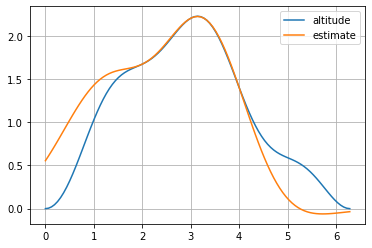

In [77]:
plt.plot(tt_dom, alt(tt_dom), label='altitude')

plt.plot(tt_dom, mu, label='estimate')

plt.grid()
plt.legend()